<a href="https://colab.research.google.com/github/ufukhurriyetoglu/vector-normalization-for-vector-search/blob/main/embeddings_and_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 🤖 NLP With Transformers Course

Similarity and Transformers
A big part of NLP relies on measuring similarity in highly-dimensional spaces. Many NLP solutions take some text, process it to create a big vector/array representing said text - then perform several transformations.

In this section we'll cover measuring sentence similarity - a great example of how powerful simple similarity metrics can be when paired with transformers.

The logic in producing a solution like this can be split into two steps:

- Take sentences, convert them into vectors (using a transformer).

- Use a similarity metric (more on this later) to find the closest matching sentences.


**Dense Vectors**

BERT and many other transformer models are able to take text, and encode a significant amount of information into vectors which represent that text. This means that semantically similar sentences, will be represented by similar vectors.

We call these vectors dense because every value within the vector has a value and has a reason for being that value - this is in contrast to sparse vectors, such as one-hot encoded vectors where the majority of values are 0. BERT is great at creating these dense vectors, and each encoder layer (there are several) outputs a set of dense vectors.

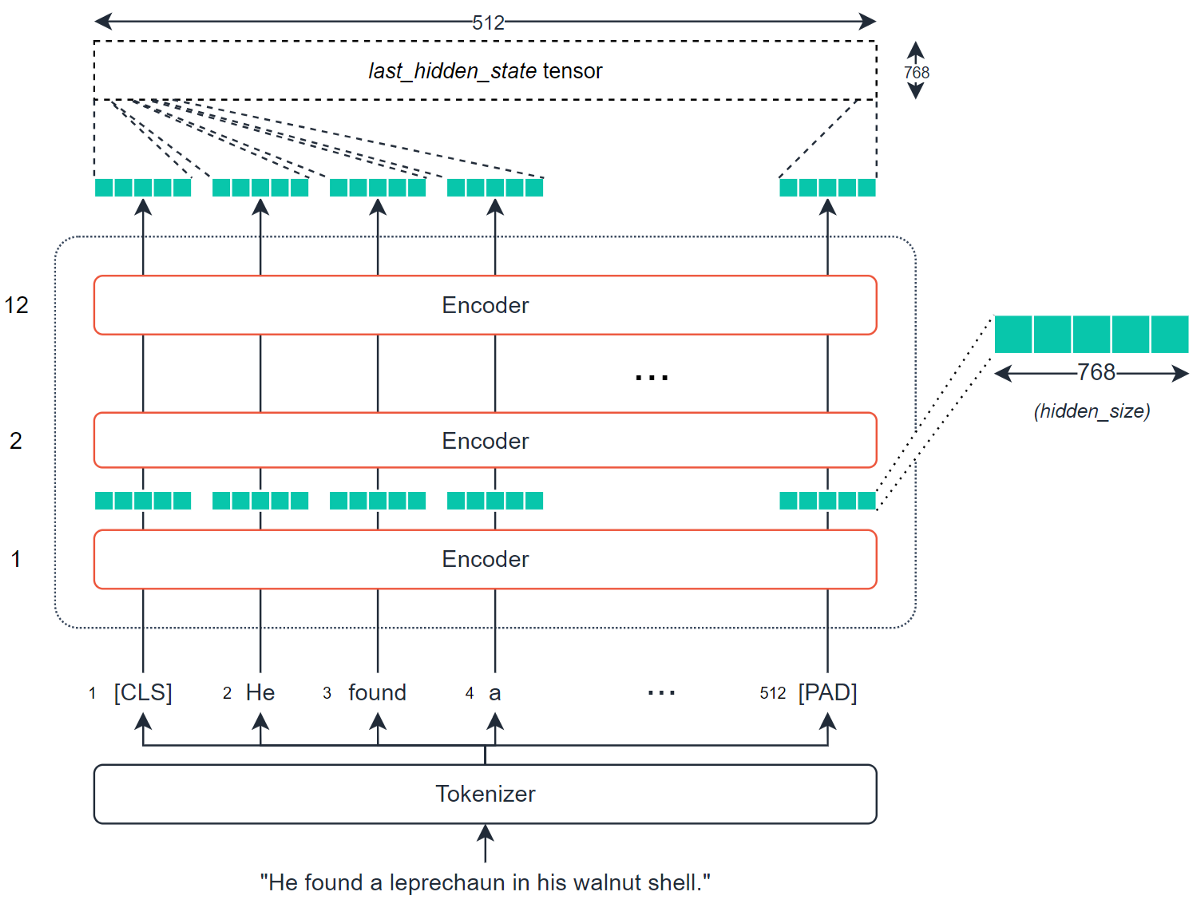

For BERT base, this will be a vector containing 768. Those 768 values contain our numerical representation of a single token - which we can use as contextual word embeddings.

Because there is one of these vectors for representing each token (output by each encoder), we are actually looking at a tensor of size 768 by the number of tokens. We can take these tensors - and transform them to create semantic representations of the input sequence. We can then take our similarity metrics and calculate the respective similarity between different sequences.

The simplest and most commonly extracted tensor is the last_hidden_state tensor - which is conveniently output by the BERT model. Of course, this is a pretty large tensor - at 512x768 - and we want a vector to apply our similarity measures to it. To do this, we need to convert our last_hidden_states tensor to a vector of 768 dimensions.

This compressed vector is our sentence embedding (or sentence vector) - it is this that we then take and compare to other sentence embeddings using a similarity metric (like cosine similarity - again, more on this later).

After that, we're done!

**Building Dense Vectors Using Transformers**

We will be using the [`sentence-transformers/stsb-distilbert-base`](https://huggingface.co/sentence-transformers/stsb-distilbert-base) model to build our dense vectors.

In [4]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.2 MB/s eta 0:00:00


In [5]:
from transformers import AutoTokenizer, AutoModel
import torch

First we initialize our model and tokenizer:

In [6]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/stsb-distilbert-base')
model = AutoModel.from_pretrained('sentence-transformers/stsb-distilbert-base')

Then we tokenize a sentence just as we have been doing before:

In [7]:
text = "hello world what a time to be alive!"

tokens = tokenizer.encode_plus(text, max_length=128,
                               truncation=True, padding='max_length',
                               return_tensors='pt')

In [9]:
tokens.keys()

dict_keys(['input_ids', 'attention_mask'])

In [10]:
tokens["input_ids"]

tensor([[ 101, 7592, 2088, 2054, 1037, 2051, 2000, 2022, 4142,  999,  102,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])

In [11]:
tokens["attention_mask"]

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

We process these tokens through our model:

In [12]:
outputs = model(**tokens)
outputs

BaseModelOutput(last_hidden_state=tensor([[[-0.9489,  0.6905, -0.2188,  ...,  0.0161,  0.5874, -0.1449],
         [-0.6643,  1.1984, -0.1346,  ...,  0.4839,  0.6338, -0.5003],
         [-0.3289,  0.6412,  0.2473,  ..., -0.0965,  0.4298,  0.0515],
         ...,
         [-0.7853,  0.8094, -0.2639,  ...,  0.2177,  0.3335,  0.1107],
         [-0.7528,  0.6285, -0.0088,  ...,  0.1024,  0.4585,  0.1720],
         [-1.0754,  0.4878, -0.3458,  ...,  0.2764,  0.5604,  0.1236]]],
       grad_fn=<NativeLayerNormBackward0>), hidden_states=None, attentions=None)

The dense vector representations of our text are contained within the outputs 'last_hidden_state' tensor, which we access like so:

In [13]:
embeddings = outputs.last_hidden_state
embeddings

tensor([[[-0.9489,  0.6905, -0.2188,  ...,  0.0161,  0.5874, -0.1449],
         [-0.6643,  1.1984, -0.1346,  ...,  0.4839,  0.6338, -0.5003],
         [-0.3289,  0.6412,  0.2473,  ..., -0.0965,  0.4298,  0.0515],
         ...,
         [-0.7853,  0.8094, -0.2639,  ...,  0.2177,  0.3335,  0.1107],
         [-0.7528,  0.6285, -0.0088,  ...,  0.1024,  0.4585,  0.1720],
         [-1.0754,  0.4878, -0.3458,  ...,  0.2764,  0.5604,  0.1236]]],
       grad_fn=<NativeLayerNormBackward0>)

In [14]:
embeddings.shape

torch.Size([1, 128, 768])

After we have produced our dense vectors `embeddings`, we need to perform a mean pooling operation on them to create a single vector encoding (the **sentence embedding**). To do this mean pooling operation we will need to multiply each value in our `embeddings` tensor by it's respective `attention_mask` value - so that we ignore non-real tokens.

To perform this operation, we first resize our `attention_mask` tensor:

In [15]:
attention_mask = tokens['attention_mask']
attention_mask.shape

torch.Size([1, 128])

In [16]:
mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
mask.shape

torch.Size([1, 128, 768])

In [17]:
attention_mask

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [18]:
mask[0][0].shape

torch.Size([768])

In [19]:
mask

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

Each vector above represents a single token attention mask - each token now has a vector of size 768 representing it's attention_mask status. Then we multiply the two tensors to apply the attention mask:

In [20]:
masked_embeddings = embeddings * mask
masked_embeddings.shape

torch.Size([1, 128, 768])

In [21]:
masked_embeddings

tensor([[[-0.9489,  0.6905, -0.2188,  ...,  0.0161,  0.5874, -0.1449],
         [-0.6643,  1.1984, -0.1346,  ...,  0.4839,  0.6338, -0.5003],
         [-0.3289,  0.6412,  0.2473,  ..., -0.0965,  0.4298,  0.0515],
         ...,
         [-0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000]]],
       grad_fn=<MulBackward0>)


Then we sum the remained of the embeddings along axis 1:

In [22]:
summed = torch.sum(masked_embeddings, 1)
summed.shape

torch.Size([1, 768])

Then sum the number of values that must be given attention in each position of the tensor:

In [23]:
summed_mask = torch.clamp(mask.sum(1), min=1e-9)
summed_mask.shape

torch.Size([1, 768])

In [24]:
summed_mask

tensor([[11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
         11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
         11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
         11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
         11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
         11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
         11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
         11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
         11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
         11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
         11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
         11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
         11., 11., 11., 11., 11., 11., 11., 11., 11.

Finally, we calculate the mean as the sum of the embedding activations summed divided by the number of values that should be given attention in each position summed_mask:

In [25]:
mean_pooled = summed / summed_mask

In [26]:
mean_pooled

tensor([[-3.8485e-01,  7.8107e-01, -1.7720e-01, -1.4125e+00, -2.3358e-01,
          9.0891e-01, -7.8390e-02,  6.0347e-01,  6.7886e-02, -3.9841e-01,
          3.9223e-02, -4.6774e-01, -7.1848e-01, -1.1863e-01, -7.1194e-02,
          6.6017e-03, -1.4093e-01,  3.1271e-01, -6.5574e-01, -1.6470e-01,
         -1.0026e-01, -3.8357e-01,  6.1278e-02, -7.3818e-01, -5.9918e-01,
          2.8855e-01,  8.6372e-01,  5.8388e-01, -3.5058e-02,  4.3197e-01,
         -5.0111e-01, -4.3498e-01,  2.3498e-01, -3.7127e-01, -1.0044e+00,
          1.0000e+00, -2.1000e+00, -3.2251e-01, -1.6085e-01, -7.3701e-01,
          5.4928e-01, -1.2066e-01,  7.2698e-01, -5.0328e-02, -1.7545e+00,
          8.0573e-01, -5.0553e-01, -4.7172e-01, -1.6727e-01,  5.9727e-01,
          5.6203e-01, -3.6104e-01, -1.6429e-01, -5.5215e-01, -5.0418e-01,
          5.6187e-01, -1.1415e+00,  1.0771e+00,  5.5689e-01, -7.0632e-02,
         -2.6932e-01, -6.8905e-01,  1.8093e-01,  3.1045e-01,  3.9036e-02,
          3.1064e-01, -4.4495e-01, -4.